## debug overturning

In [14]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [15]:
import numpy as np
from cmocean import cm
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
from importlib import reload
import glob
import pandas as pd
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

## summary
#### Objective: 
    
- We are trying to calculate the overturning circulation in two global ocean models (TOM12 and UKESM) using https://github.com/meom-group/CDFTOOLS

- Two ways, depth and sigma coordinates:

- The routine `./cdfmoc` calculates overturning circulation in depth coordinates and needs a v-velocity file (variable name `vomecrty`)

- `./cdfmocsig` should calculate the overturning ciculation in sigma coordinates and and needs both a v-velocity file (variable name `vomecrty`) and a t-file with votemper and vosaline

- for TOM, this calculation has been ok and gives consistent results in depth coordinates.
- however, I believe I may be missing some steps for the sigma coordinates.

- for UKESM, I  have run into a number of problems, I believe partly because neither the variable names nor the meshmask were of a standard format. Here I try to summarize what I've found out.


## A - running for TOM12: basically works
1) start in login node
2) add modules

    `module add gcc/10.3.0`
    
    `module add netcdf/4.7.4/gcc`

3) cd to toolbox, which is here: `cd /gpfs/home/mep22dku/cdftools`

3) symlink tom mask, I made a script: `bash link_tommask.sh` (note linking new_maskglo.nc is currently commented out, so only global mesh mask is calculated)

4) test both routines (put in bashscript called test_tom.sh)

    contents of bashscript:

    `./cdfmoc -v ./RIV12_PT_ER24_y1955_grid_V.nc `
    
    `mv moc.nc ./testresults/RIV12_PT_ER24_y1955_MOC.nc`

    `./cdfmocsig -v ./RIV12_PT_ER24_y1955_grid_V.nc -t TOM12_TJ_1ASA_y1955_grid_T.nc`
    
    `mv mocsig.nc ./testresults/RIV12_PT_ER24_y1955_MOC.nc`


In [16]:
tom_gridV = xr.open_dataset('/gpfs/home/mep22dku/cdftools/RIV12_PT_ER24_y1955_grid_V.nc')
tom_gridT = xr.open_dataset('/gpfs/home/mep22dku/cdftools/TOM12_TJ_1ASA_y1955_grid_T.nc') #grid T from different model because PT's doesn't have salinity

tom_MOCtest = xr.open_dataset('/gpfs/home/mep22dku/cdftools/testresults/RIV12_PT_ER24_y1955_MOC.nc')
tom_MOCSIG_r0test = xr.open_dataset('/gpfs/home/mep22dku/cdftools/testresults/RIV12_PT_ER24_y1955_MOCSIG_r0.nc')
tom_MOCSIG_r1000test = xr.open_dataset('/gpfs/home/mep22dku/cdftools/testresults/RIV12_PT_ER24_y1955_MOCSIG_r1000.nc')

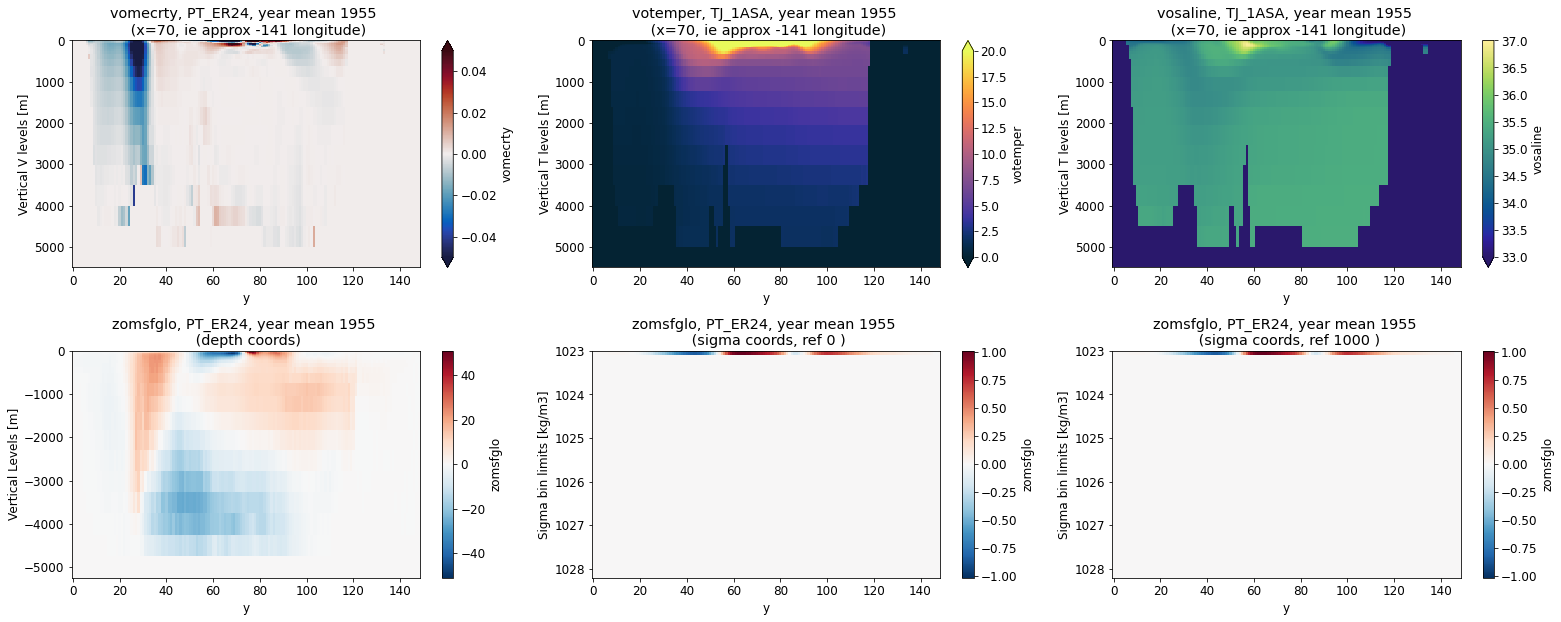

In [17]:
q = int(tom_gridV.nav_lon.isel(x = 70, y = 50).values)

fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(20*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

xr.plot.pcolormesh(tom_gridV.vomecrty.isel(x = 70).mean(dim = 'time_counter'), \
                   ax = axs[0], vmin = -0.05, vmax = 0.05, cmap = cm.balance)
axs[0].set_title(f'vomecrty, PT_ER24, year mean 1955 \n (x=70, ie approx {q} longitude)')

xr.plot.pcolormesh(tom_gridT.votemper.isel(x = 70).mean(dim = 'time_counter'), \
                   ax = axs[1], vmin = 0, vmax = 20, cmap = cm.thermal)
axs[1].set_title(f'votemper, TJ_1ASA, year mean 1955 \n (x=70, ie approx {q} longitude)')

xr.plot.pcolormesh(tom_gridT.vosaline.isel(x = 70).mean(dim = 'time_counter'), \
                   ax = axs[2], vmin = 33, vmax = 37, cmap = cm.haline)
axs[2].set_title(f'vosaline, TJ_1ASA, year mean 1955 \n (x=70, ie approx {q} longitude)')


xr.plot.pcolormesh(tom_MOCtest.zomsfglo.mean(dim = 'time_counter').isel(x=0), \
                   ax = axs[3])
axs[3].set_title(f'zomsfglo, PT_ER24, year mean 1955 \n (depth coords)')

xr.plot.pcolormesh(tom_MOCSIG_r0test.zomsfglo.mean(dim = 'time_counter').isel(x=0), \
                   ax = axs[4])
axs[4].set_title(f'zomsfglo, PT_ER24, year mean 1955 \n (sigma coords, ref 0 )')
axs[4].invert_yaxis()

xr.plot.pcolormesh(tom_MOCSIG_r1000test.zomsfglo.mean(dim = 'time_counter').isel(x=0), \
                   ax = axs[5])
axs[5].set_title(f'zomsfglo, PT_ER24, year mean 1955 \n (sigma coords, ref 1000 )')
axs[5].invert_yaxis()

for i in range(0,3):
    axs[i].invert_yaxis()
    
plt.tight_layout()

## B) running the same protocols on UKESM

as above, load modules and link meshmask:
(the following commands are also in test_ukesm in the cdftools directory:)

        ./cdfmoc -v ./nemo_bc370_1y_1955_grid-V-vomecrty.nc
        mv moc.nc ./testresults/UKESM1_y1955_MOC.nc

        ./cdfmocsig -v ./nemo_bc370_1y_1955_grid-V-vomecrty.nc -t nemo_bc370_1y_1955_grid-T-TS.nc -r 1000
        mv mocsig.nc ./testresults/UKESM1_y1955_MOCSIG_r1000.nc
        ./cdfmocsig -v ./nemo_bc370_1y_1955_grid-V-vomecrty.nc -t nemo_bc370_1y_1955_grid-T-TS.nc -r 0
        mv mocsig.nc ./testresults/UKESM1_y1955_MOCSIG_r0.nc

In [18]:
ukesm_gridV = xr.open_dataset('/gpfs/home/mep22dku/cdftools/nemo_bc370_1y_1955_grid-V-vomecrty.nc')
ukesm_gridT = xr.open_dataset('/gpfs/home/mep22dku/cdftools/nemo_bc370_1y_1955_grid-T-TS.nc')

ukesm_MOCtest = xr.open_dataset('/gpfs/home/mep22dku/cdftools/testresults/UKESM1_y1955_MOC.nc')
ukesm_MOCSIG_r0test = xr.open_dataset('/gpfs/home/mep22dku/cdftools/testresults/UKESM1_y1955_MOCSIG_r0.nc')
ukesm_MOCSIG_r1000test = xr.open_dataset('/gpfs/home/mep22dku/cdftools/testresults/UKESM1_y1955_MOCSIG_r1000.nc')


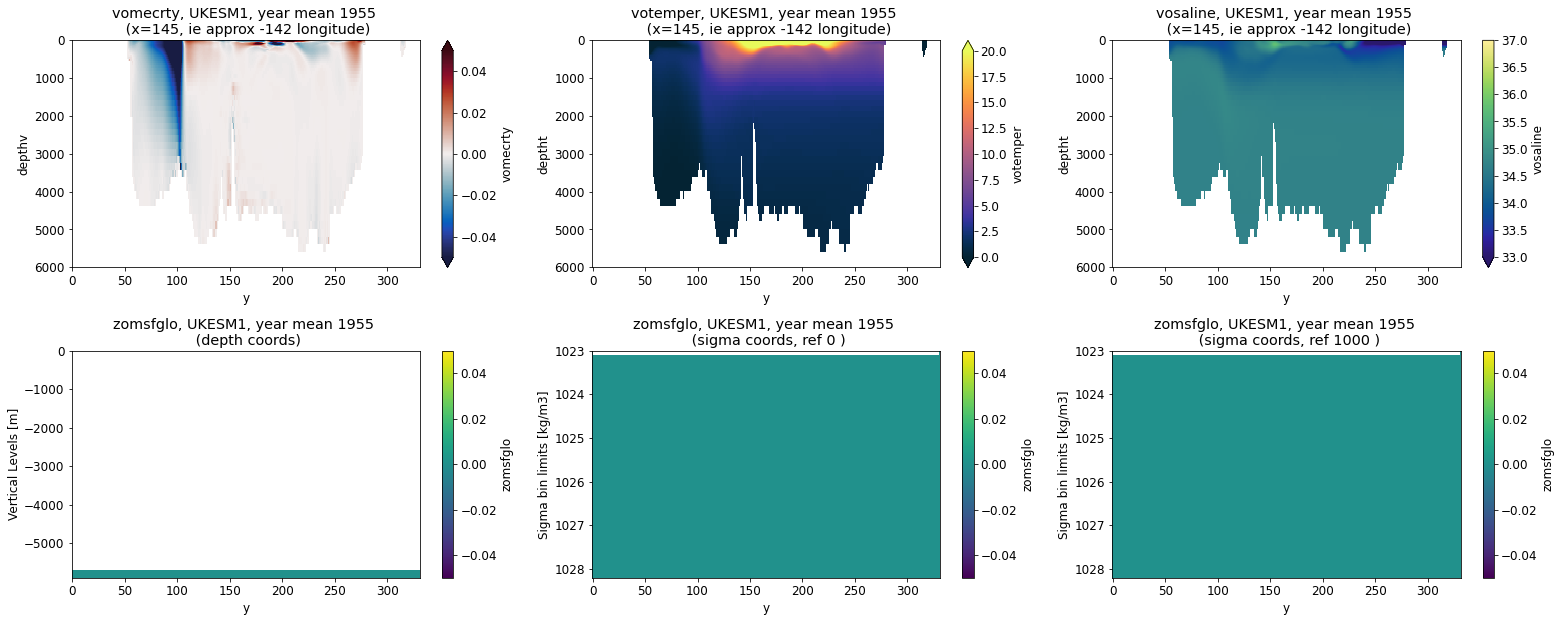

In [19]:
tx = 145

q = int(ukesm_gridV.nav_lon.isel(x = tx, y = 50).values)

fact = 1.1
fig, axs = plt.subplots(2,3, figsize=(20*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

xr.plot.pcolormesh(ukesm_gridV.vomecrty.isel(x = tx).mean(dim = 'time_counter'), \
                   ax = axs[0], vmin = -0.05, vmax = 0.05, cmap = cm.balance)
axs[0].set_title(f'vomecrty, UKESM1, year mean 1955 \n (x={tx}, ie approx {q} longitude)')

xr.plot.pcolormesh(ukesm_gridT.votemper.isel(x = tx).mean(dim = 'time_counter'), \
                   ax = axs[1], vmin = 0, vmax = 20, cmap = cm.thermal)
axs[1].set_title(f'votemper, UKESM1, year mean 1955 \n (x={tx}, ie approx {q} longitude)')

xr.plot.pcolormesh(ukesm_gridT.vosaline.isel(x = tx).mean(dim = 'time_counter'), \
                   ax = axs[2], vmin = 33, vmax = 37, cmap = cm.haline)
axs[2].set_title(f'vosaline, UKESM1, year mean 1955 \n (x={tx}, ie approx {q} longitude)')


xr.plot.pcolormesh(ukesm_MOCtest.zomsfglo.mean(dim = 'time_counter').isel(x=0), \
                   ax = axs[3])
axs[3].set_title(f'zomsfglo, UKESM1, year mean 1955 \n (depth coords)')

xr.plot.pcolormesh(ukesm_MOCSIG_r0test.zomsfglo.mean(dim = 'time_counter').isel(x=0), \
                   ax = axs[4])
axs[4].set_title(f'zomsfglo, UKESM1, year mean 1955 \n (sigma coords, ref 0 )')
axs[4].invert_yaxis()

xr.plot.pcolormesh(ukesm_MOCSIG_r1000test.zomsfglo.mean(dim = 'time_counter').isel(x=0), \
                   ax = axs[5])
axs[5].set_title(f'zomsfglo, UKESM1, year mean 1955 \n (sigma coords, ref 1000 )')
axs[5].invert_yaxis()

for i in range(0,3):
    axs[i].invert_yaxis()
    
plt.tight_layout()

## B2

./cdfmoc -v ./VOMECRTY_nemo_bc370o_1m_20090401-20090501_grid-V.nc

In [20]:
testvo = xr.open_dataset('/gpfs/home/mep22dku/cdftools/VOMECRTY_nemo_bc370o_1m_20090401-20090501_grid-V.nc')
testmoc = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/CDFTOOLS_JL/bin/moc.nc')



In [28]:
testmoc.zomsfglo.values

array([[[[ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         ...,
         [-1.98990162e-02],
         [-5.50388153e+23],
         [-1.08227905e+24]],

        [[ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         ...,
         [-3.96215245e-02],
         [-5.49974038e+23],
         [-1.08153419e+24]],

        [[ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         ...,
         [-6.05898201e-02],
         [-5.49537585e+23],
         [-1.08074912e+24]],

        ...,

        [[ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        [[ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         ...,
         [ 0.00000000e+00],
         [ 0.00000000e+00],
         [ 0.00000000e+00]],

        [[ 0.00000000e+00],
         [ 0.00000000e+00],
         [

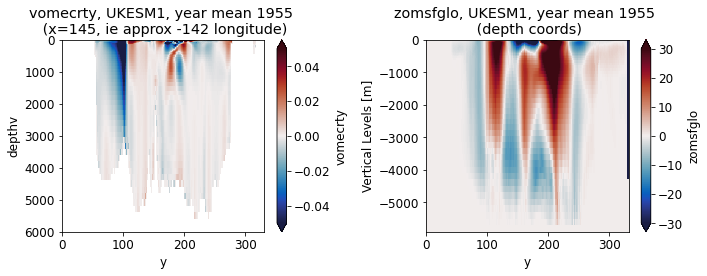

In [33]:
tx = 145

q = int(testvo.nav_lon.isel(x = tx, y = 50).values)

fact = 0.5
fig, axs = plt.subplots(1,2, figsize=(20*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

xr.plot.pcolormesh(testvo.vomecrty.isel(x = tx).mean(dim = 'time_counter'), \
                   ax = axs[0], vmin = -0.05, vmax = 0.05, cmap = cm.balance)
axs[0].set_title(f'vomecrty, UKESM1, year mean 1955 \n (x={tx}, ie approx {q} longitude)')

# xr.plot.pcolormesh(ukesm_gridT.votemper.isel(x = tx).mean(dim = 'time_counter'), \
#                    ax = axs[1], vmin = 0, vmax = 20, cmap = cm.thermal)
# axs[1].set_title(f'votemper, UKESM1, year mean 1955 \n (x={tx}, ie approx {q} longitude)')

# xr.plot.pcolormesh(ukesm_gridT.vosaline.isel(x = tx).mean(dim = 'time_counter'), \
#                    ax = axs[2], vmin = 33, vmax = 37, cmap = cm.haline)
# axs[2].set_title(f'vosaline, UKESM1, year mean 1955 \n (x={tx}, ie approx {q} longitude)')


xr.plot.pcolormesh(testmoc.zomsfglo.mean(dim = 'time_counter').isel(x=0), \
                   ax = axs[1], vmin = -30, vmax = 30, cmap = cm.balance)
axs[1].set_title(f'zomsfglo, UKESM1, year mean 1955 \n (depth coords)')

# xr.plot.pcolormesh(ukesm_MOCSIG_r0test.zomsfglo.mean(dim = 'time_counter').isel(x=0), \
#                    ax = axs[4])
# axs[4].set_title(f'zomsfglo, UKESM1, year mean 1955 \n (sigma coords, ref 0 )')
# axs[4].invert_yaxis()

# xr.plot.pcolormesh(ukesm_MOCSIG_r1000test.zomsfglo.mean(dim = 'time_counter').isel(x=0), \
#                    ax = axs[5])
# axs[5].set_title(f'zomsfglo, UKESM1, year mean 1955 \n (sigma coords, ref 1000 )')
axs[0].invert_yaxis()

    
plt.tight_layout()

## C understanding the meshmasks

-The UKESM meshmask `mesh_mask_eORCA1_wrk.nc` had some inconsistent naming - e.g. 

    in TOM but not in UKESM
    ['e3u_0', 'gdept_1d', 'e3v_0', 'gdepw_1d', 'e3t_1d', 'e3w_1d']

    in UKESM but not in TOM
    ['e3u', 'gdept,', 'e3w', 'e3t', 'gdepw', 'e3v']
I tried to rewrite the UKESM mesh mask such that it follows exactly the format of the TOM one, since I know the TOM one works. 

- here i list the respective names, data types, and dimensions of the two mesh masks
- I also plot them side by side where possible to make sure there are no inconsistencies, everything looks ok. 

In [22]:
mtom = xr.open_dataset('/gpfs/home/mep22dku/cdftools/mesh_mask3_6.nc')
mukesm = xr.open_dataset('/gpfs/home/mep22dku/cdftools/mesh_mask_eORCA1_wrk.nc') #old inconsistent mesh mask
mukesm_new = xr.open_dataset('/gpfs/home/mep22dku/cdftools/testUKESMmask1.nc') #remade

In [23]:
tvar = list(mtom.keys())

print(f'tom meshmask has {len(list(mtom.keys()))} variables')
print(f'ukesm meshmask has {len(list(mtom.keys()))} variables')

tom meshmask has 44 variables
ukesm meshmask has 44 variables


nav_lon
var nav_lon in TOM meshmask , dtype float32, shape (149, 182), dims = ('y', 'x')
var nav_lon in UKESM meshmask , dtype float32, shape (332, 362), dims = ('y', 'x')
-------------------------------

nav_lat
var nav_lat in TOM meshmask , dtype float32, shape (149, 182), dims = ('y', 'x')
var nav_lat in UKESM meshmask , dtype float32, shape (332, 362), dims = ('y', 'x')
-------------------------------

nav_lev
var nav_lev in TOM meshmask , dtype float32, shape (31,), dims = ('z',)
var nav_lev in UKESM meshmask , dtype float32, shape (75,), dims = ('z',)
-------------------------------

time_counter
var time_counter in TOM meshmask , dtype float64, shape (1,), dims = ('t',)
var time_counter in UKESM meshmask , dtype float64, shape (1,), dims = ('t',)
-------------------------------

tmask
var tmask in TOM meshmask , dtype int8, shape (1, 31, 149, 182), dims = ('t', 'z', 'y', 'x')
var tmask in UKESM meshmask , dtype int8, shape (1, 75, 332, 362), dims = ('t', 'z', 'y', 'x')
---------

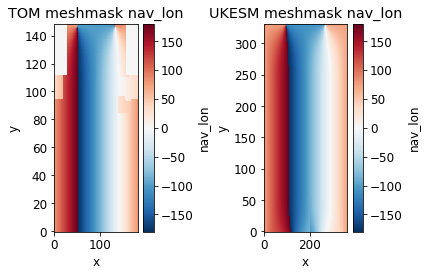

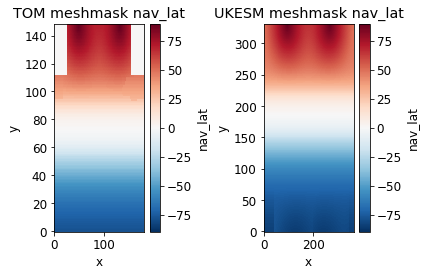

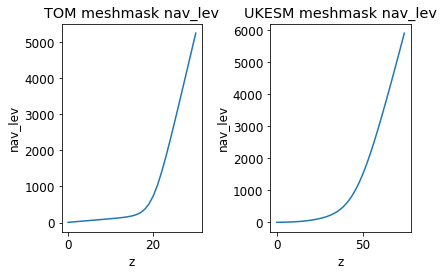

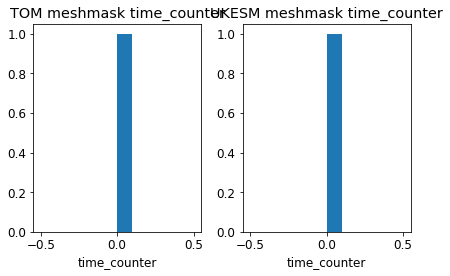

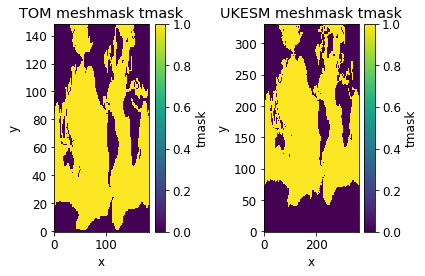

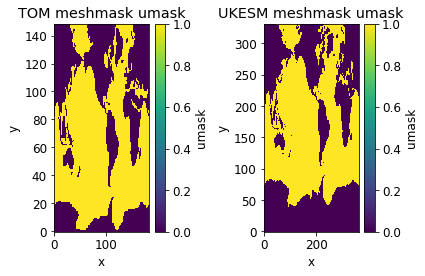

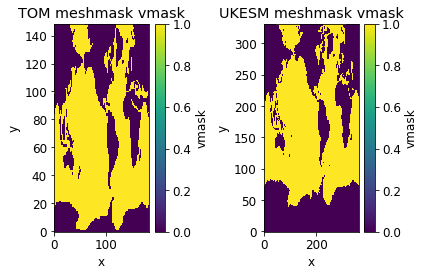

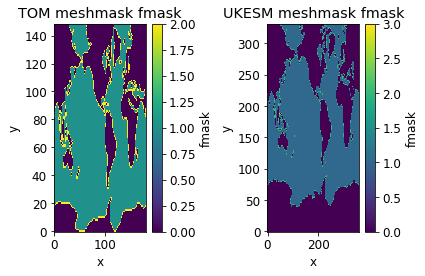

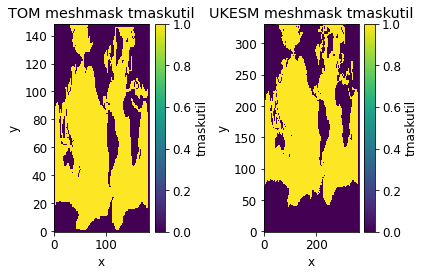

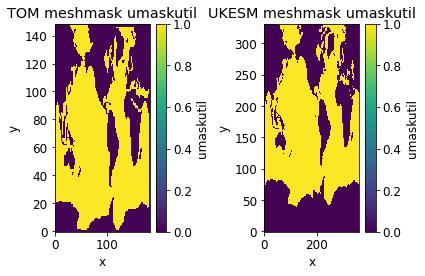

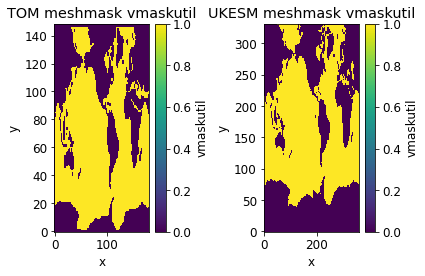

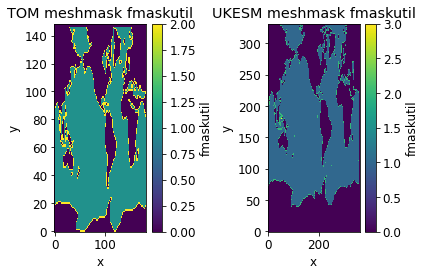

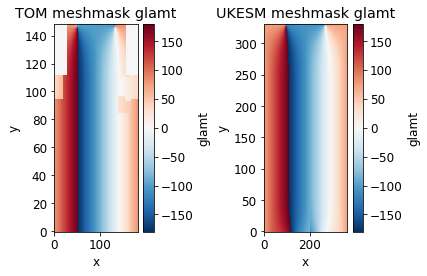

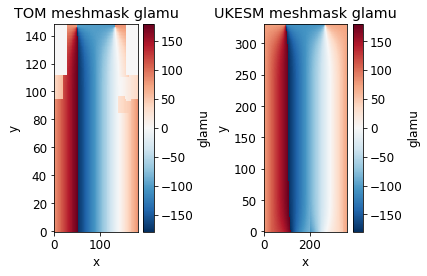

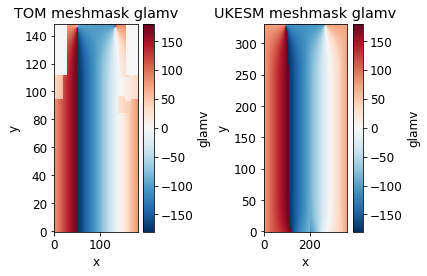

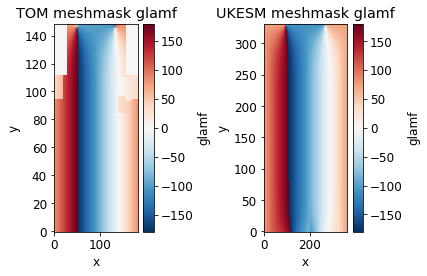

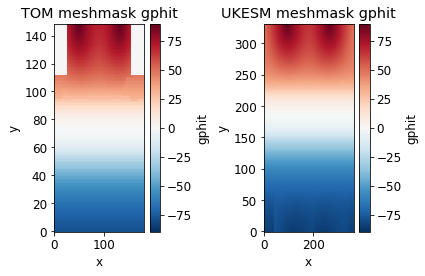

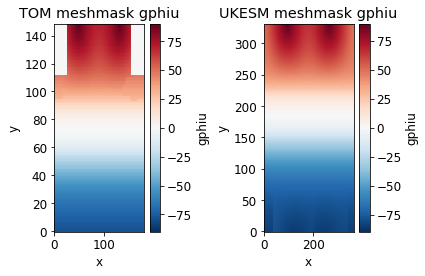

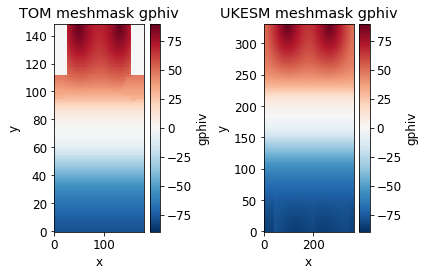

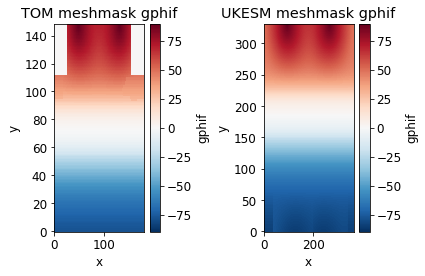

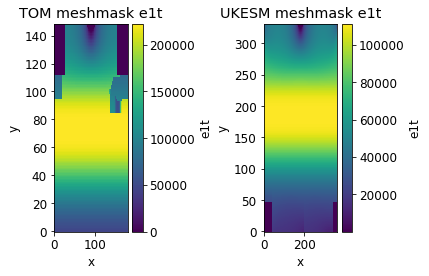

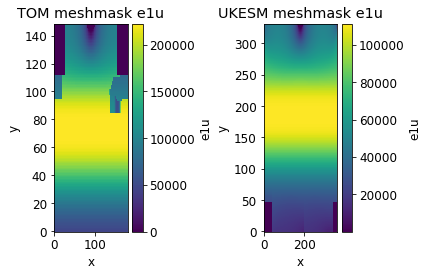

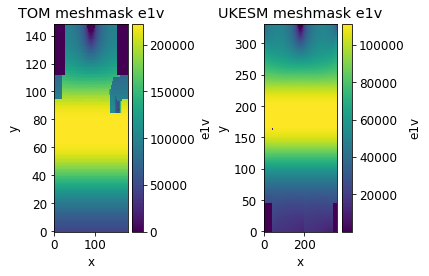

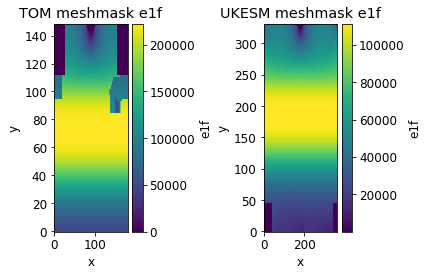

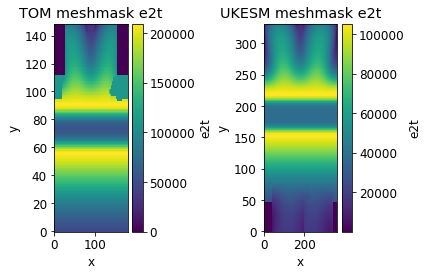

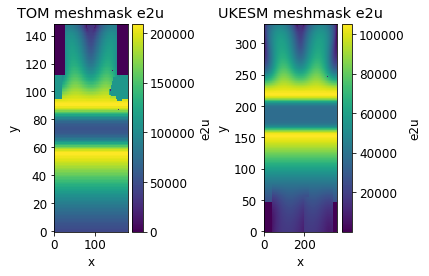

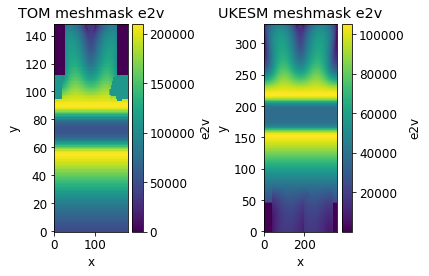

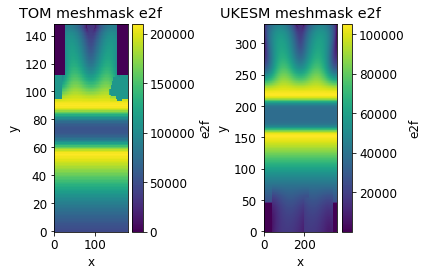

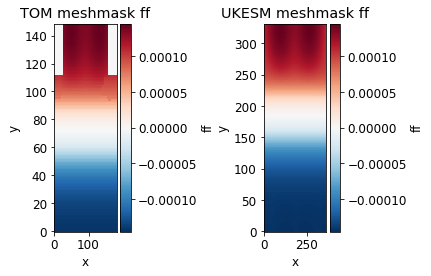

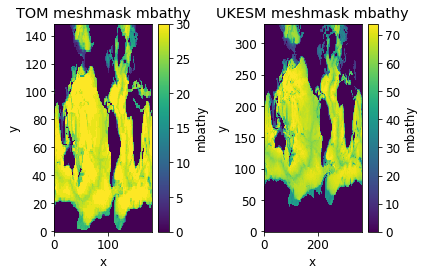

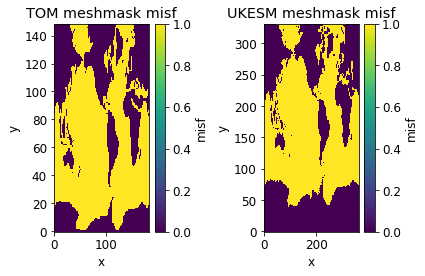

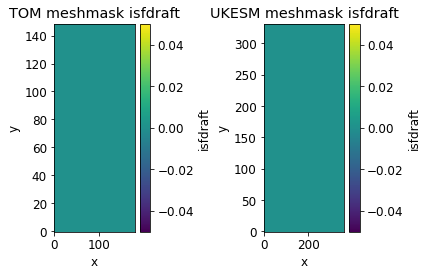

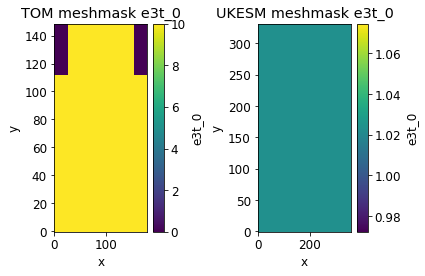

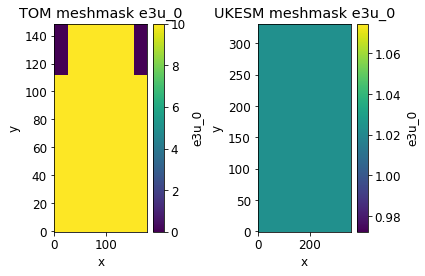

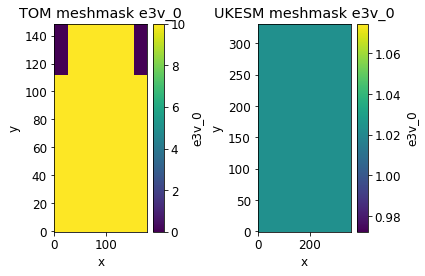

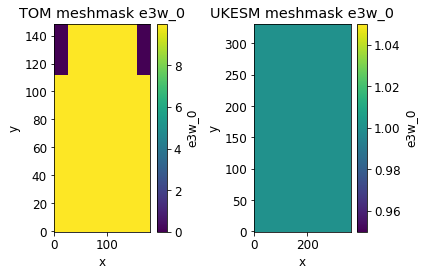

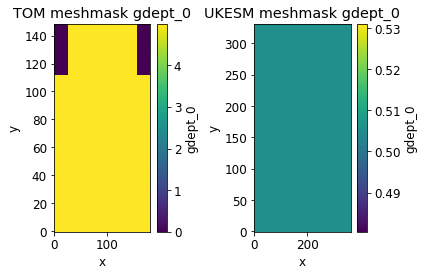

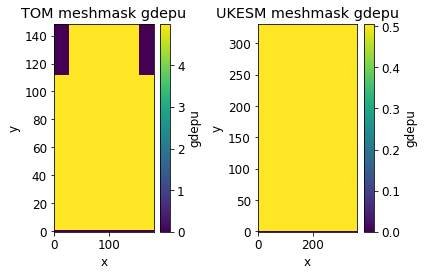

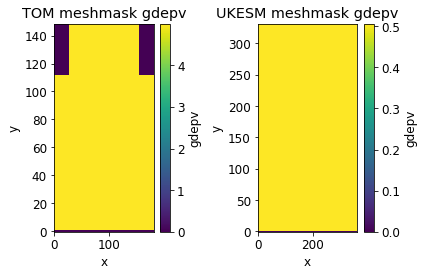

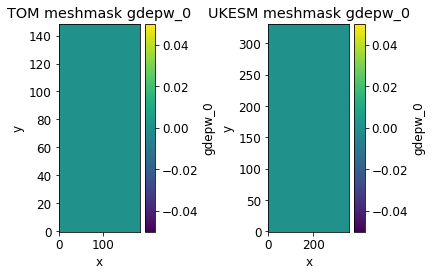

In [24]:
tvar = list(mtom.keys())

for i in range(0, len(tvar)):
    
    print(tvar[i])
    print(f'var {tvar[i]} in TOM meshmask , dtype {mtom[tvar[i]].dtype}, shape {mtom[tvar[i]].shape}, dims = {mtom[tvar[i]].dims}')
    print(f'var {tvar[i]} in UKESM meshmask , dtype {mukesm_new[tvar[i]].dtype}, shape {mukesm_new[tvar[i]].shape}, dims = {mukesm_new[tvar[i]].dims}')
    ndim = (len(mtom[tvar[i]].dims))

    if ((ndim == 2) & (mtom[tvar[i]].shape[0] != 1)):
        fact =0.5
        fig, axs = plt.subplots(1,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
        axs = axs.ravel()
        xr.plot.pcolormesh(mtom[tvar[i]], ax = axs[0])
        axs[0].set_title(f'TOM meshmask {tvar [i]}')
        xr.plot.pcolormesh(mukesm_new[tvar[i]], ax = axs[1])
        axs[1].set_title(f'UKESM meshmask {tvar [i]}')
        plt.tight_layout()
        
    if (ndim == 1):
        fact =0.5
        fig, axs = plt.subplots(1,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
        axs = axs.ravel()
        xr.plot.plot(mtom[tvar[i]], ax = axs[0])
        axs[0].set_title(f'TOM meshmask {tvar [i]}')
        xr.plot.plot(mukesm_new[tvar[i]], ax = axs[1])
        axs[1].set_title(f'UKESM meshmask {tvar [i]}')
        plt.tight_layout()
        
    if (ndim == 3):
        fact =0.5
        fig, axs = plt.subplots(1,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
        axs = axs.ravel()
        xr.plot.plot(mtom[tvar[i]][0,:,:], ax = axs[0])
        axs[0].set_title(f'TOM meshmask {tvar [i]}')
        xr.plot.plot(mukesm_new[tvar[i]][0,:,:], ax = axs[1])
        axs[1].set_title(f'UKESM meshmask {tvar [i]}')
        plt.tight_layout()
        
    if (ndim == 4):
        fact =0.5
        fig, axs = plt.subplots(1,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
        axs = axs.ravel()
        xr.plot.plot(mtom[tvar[i]][0,0,:,:], ax = axs[0])
        axs[0].set_title(f'TOM meshmask {tvar [i]}')
        xr.plot.plot(mukesm_new[tvar[i]][0,0,:,:], ax = axs[1])
        axs[1].set_title(f'UKESM meshmask {tvar [i]}')
        plt.tight_layout()


    print('-------------------------------')
    print('')

## ok what about the files 

In [25]:
ts_file_ukesm = xr.open_dataset('/gpfs/home/mep22dku/cdftools/nemo_bc370_1y_1955_grid-T-TS.nc')
ts_file_tom = xr.open_dataset('/gpfs/home/mep22dku/cdftools/TOM12_TJ_1ASA_y1955_grid_T.nc')

v_file_ukesm = xr.open_dataset('/gpfs/home/mep22dku/cdftools/nemo_bc370_1y_1955_grid-V-vomecrty.nc')
v_file_tom = xr.open_dataset('/gpfs/home/mep22dku/cdftools/RIV12_PT_ER24_y1955_grid_V.nc')

In [26]:
f'var {tvar[i]} in TOM meshmask , dtype {mtom[tvar[i]].dtype}, shape {mtom[tvar[i]].shape}, dims = {mtom[tvar[i]].dims}')

SyntaxError: invalid syntax (2620641964.py, line 1)

In [ ]:
v_file_tom

In [ ]:
tom_MOCtest

In [ ]:
ukesm_MOCtest